In [1]:
%matplotlib inline
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import os
from src.simple_utils import load_pickle
from src.data_utils import cifar10_label_names, get_dataset
from os.path import join
from cifarclass import cifar100_classes
from scipy.interpolate import interp1d

import seaborn as sns
import colorcet as cc
from ipdb import set_trace
import pandas as pd
import umap

label_mapping=cifar100_classes
classes = list(label_mapping.values())

alpha =0.2 
markersize=12

indices = np.random.default_rng(1).choice(np.arange(10000), size=10)

In [2]:
name = "CIFAR100_test"
# name of training dataset
train_set = "CIFAR100_train"

print("loading data")
grouped = load_pickle('../processed/cifar100/clip_new/group2.pkl')
scores = load_pickle('../processed/cifar100/clip_new/scores.pkl')
print("done")

print("loading dataset")
dataset = get_dataset('data', name)
ytest = np.array(dataset.targets)
print("done")

loading data
done
loading dataset
Files already downloaded and verified
done


In [3]:
# preprocessing: compute soft-accuracies
def probs_to_softacc(probs):
    return np.array([probs[i, yi, :] for i, yi in enumerate(ytest)]).mean(0)

softacc = probs_to_softacc(grouped[name]['ClipViTB32']['probs'])

In [4]:
def cut_labels(y, labels, k=8):
    good = np.argpartition(np.sum(y, axis=1), -k)[-k:]
    bad = set(range(100)).difference(set(list(good)))
    for i in bad:
        labels[i] = '_nolegend_'
    return labels

def stackplot(index, types = ["probs","freqs"], plot_group = "ClipViTB32"):
    dct = grouped[name][plot_group]
    print("index %d" % index)
    img, label = dataset.__getitem__(index)
    img = np.array(img)
    col = sns.color_palette(cc.glasbey, n_colors=25)

    for t in types:
        print(t)
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
        y = dct[t][index].copy() # probs/freqs
        
        ind = np.argsort(y[:,-1])[::-1] # sort labels according to their final probabilities
        #set_trace()
        print(f"Top 5 are {ind[:5]}")
        print(f"Prediction is {classes[ind[0]]}")
        y = y[ind]
        labels = [classes[ind[i]] for i in range(len(classes))]
        new_label = list(ind).index(label)
        
        # swap in the true-label as the first label in list (and in y)
        labels[0], labels[new_label] = labels[new_label], labels[0]
        y[[0,new_label]] = y[[new_label,0]]
        
        #truth = classes[label]
        labels = cut_labels(y, labels)
        #labels[0] = truth
        

            
        if t=="probs":
            xx = probs_to_softacc(dct["probs"])
            ax1.set_xlabel("Soft-Test acc on %s" % name, fontsize=16)
            ax1.set_ylabel("Softmax probabilities", fontsize=16)
        
        else:
            xx = dct["x"]
            ax1.set_xlabel("Test acc on %s" % name, fontsize=16)
            ax1.set_ylabel("Frequency of predictions", fontsize=16)
            
        
        ax1.stackplot(xx, y, labels=labels, colors = col)
        ax1.set_title(
            "Train %s, architecture %s" % (train_set, plot_group),
            fontsize=20,
        )

        ax1.legend(loc="best")
        ax2.imshow(img, interpolation="nearest")
        ax2.set_title("Index %d from %s, class: %s" % (index, name, classes[label]), fontsize=20)
        plt.show()

In [5]:
G = grouped[name]['ClipViTB32']

def get_embedding(index, G=grouped[name]['ClipViTB32'], topk=5, gridpts=50):
    true_label = ytest[index]
    
    x = G["x"]
    areas = G["freqs"][index].sum(axis=1)
    areas[true_label] = +np.infty # force true label to be first
    ind = np.argsort(areas)[::-1] # sort labels according to their integrals
    top_labels = ind[:topk]

    embed = []
    xx = np.linspace(x.min(), x.max(), gridpts)
    for lab in top_labels:
        # linearly interpolate the curve on uniform grid
        y = G["freqs"][index][lab]
        f = interp1d(x, y, kind='linear')
        yy = f(xx)
        embed.append(yy)
    return np.array(embed) # topk x gridpts

(5, 50)


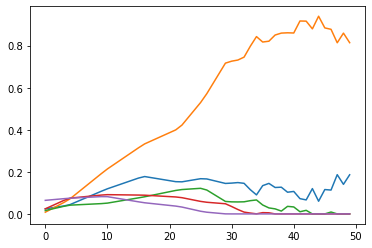

In [19]:
e = get_embedding(np.random.randint(10000), topk=5)
print(e.shape)
plt.figure()
for i in range(len(e)):
    plt.plot(e[i])
plt.show()

(5000, 250)
(5000, 2)


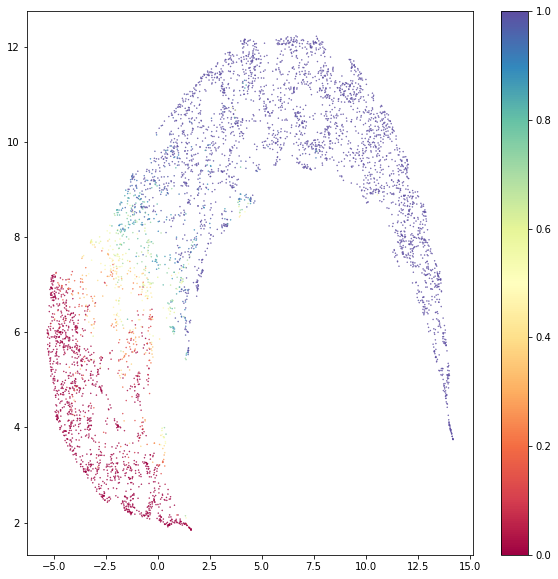

In [20]:
N = 5000
X = np.array([ get_embedding(i, topk=5).flatten() for i in range(N) ])
print(X.shape)

Xt = umap.UMAP().fit_transform(X)
print(Xt.shape)

final_accs = np.array([G["freqs"][i, yi, -1] for i, yi in enumerate(ytest)])

plt.figure(figsize=(10,10))
sc = plt.scatter(Xt[:, 0], Xt[:, 1], s=0.2, c=final_accs[:N], cmap='Spectral')
plt.colorbar(sc)
plt.show()

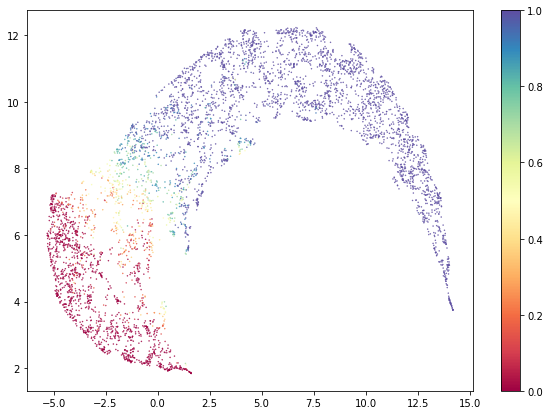

In [22]:
plt.figure(figsize=(10,7))
sc = plt.scatter(Xt[:, 0], Xt[:, 1], s=0.2, c=final_accs[:N], cmap='Spectral')
plt.colorbar(sc)
plt.show()

In [180]:
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
from io import BytesIO
from PIL import Image
import base64

def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

from bokeh.plotting import bfigure, bshow, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

output_notebook()


ModuleNotFoundError: No module named 'bokeh'

In [ ]:
df = pd.DataFrame(Xt, columns=('x', 'y'))
df['class'] = [classes[ytest[i]] for i in range(N)]
df['image'] = list(map(embeddable_image, digits.images))

datasource = ColumnDataSource(digits_df)
color_mapping = CategoricalColorMapper(factors=[str(9 - x) for x in digits.target_names],
                                       palette=Spectral10)

plot_figure = bfigure(
    title='UMAP projection of the Digits dataset',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Digit:</span>
        <span style='font-size: 18px'>@digit</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='digit', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)
bshow(plot_figure)